In [3]:
# Download data from Kaggle
!pip install kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c aptos2019-blindness-detection
!unzip aptos2019-blindness-detection.zip -d /content/aptos_data
›


In [1]:
# Import Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Number of valid samples: 3662
        id_code  diagnosis                                          file_path
0  000c1434d8d7          2  /content/aptos_data/train_images/000c1434d8d7.png
1  001639a390f0          4  /content/aptos_data/train_images/001639a390f0.png
2  0024cdab0c1e          1  /content/aptos_data/train_images/0024cdab0c1e.png
3  002c21358ce6          0  /content/aptos_data/train_images/002c21358ce6.png
4  005b95c28852          0  /content/aptos_data/train_images/005b95c28852.png


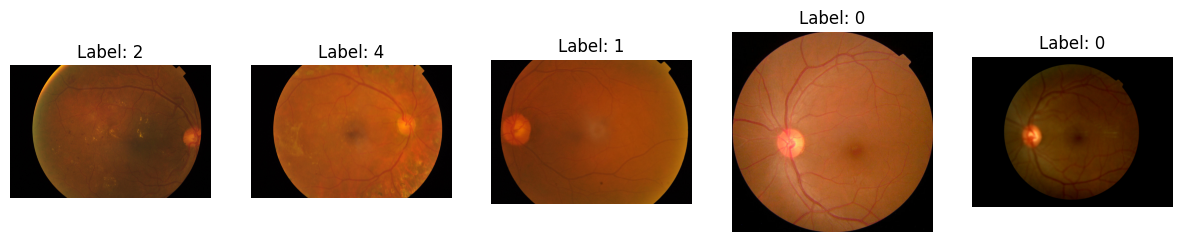

Train set: (2929, 224, 224, 3), Validation set: (366, 224, 224, 3), Test set: (367, 224, 224, 3)


In [ ]:
# Set Paths and Constants
IMG_SIZE = 224  # Image size for resizing
data_dir = '/content/aptos_data'  # Adjust as needed
train_csv_path = os.path.join(data_dir, 'train.csv')
train_images_path = os.path.join(data_dir, 'train_images')

# Load Dataset and Perform Data Cleaning
train_data = pd.read_csv(train_csv_path)
train_data['file_path'] = train_data['id_code'].apply(lambda x: os.path.join(train_images_path, f"{x}.png"))

# Check for missing or corrupted files
valid_paths = train_data['file_path'].apply(os.path.exists)
if not valid_paths.all():
    print(f"Missing or corrupted images detected: {len(train_data) - valid_paths.sum()} files")
    train_data = train_data[valid_paths]

print(f"Number of valid samples: {len(train_data)}")
print(train_data.head())

# Display Sample Images
def display_images(data, img_path, n=5):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        image_id = data.iloc[i]['id_code']
        label = data.iloc[i]['diagnosis']
        img = Image.open(os.path.join(img_path, f"{image_id}.png"))
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

display_images(train_data, train_images_path, n=5)

# Preprocess Data (Resizing and Normalization)
def preprocess_image(img_path):
    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img) / 255.0  # Normalize to [0, 1]
    return img

# Load images and preprocess
X = np.array([preprocess_image(img_path) for img_path in train_data['file_path']])
y = train_data['diagnosis'].values
y = to_categorical(y, num_classes=5)  # One-hot encode labels

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

# Data Augmentation
data_gen = ImageDataGenerator(
    rotation_range=20,     # Rotation
    zoom_range=0.15,       # Zoom
    horizontal_flip=True,  # Horizontal flipping
    vertical_flip=True,    # Vertical flipping
    fill_mode='nearest'    # Fill pixels
)

# Augment training data
train_generator = data_gen.flow(X_train, y_train, batch_size=32)

# Build and Train Autoencoder
def build_autoencoder(input_shape):
    # Encoder
    input_img = Input(shape=input_shape)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = MaxPooling2D((2, 2), padding='same')(x)

    # Decoder
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = UpSampling2D((2, 2))(x)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    # Autoencoder Model
    autoencoder = Model(input_img, decoded)
    encoder = Model(input_img, encoded)
    return autoencoder, encoder

input_shape = (IMG_SIZE, IMG_SIZE, 3)
autoencoder, encoder = build_autoencoder(input_shape)

autoencoder.compile(optimizer=Adam(), loss='mse')
autoencoder.summary()

# Train Autoencoder
autoencoder.fit(X_train, X_train,
                validation_data=(X_val, X_val),
                epochs=10,
                batch_size=32,
                verbose=1)
autoencoder.save('autoencoder_aptos.h5')
encoder.save('encoder_aptos.h5')

# Build CNN Model Using Encoder Features
def build_cnn_with_encoder(encoder, num_classes):
    model = Sequential([
        encoder,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

cnn_model = build_cnn_with_encoder(encoder, num_classes)

cnn_model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
cnn_model.summary()

# Train CNN Model with Augmented Data
history = cnn_model.fit(train_generator,
                        validation_data=(X_val, y_val),
                        epochs=20,
                        verbose=1)

# Save the trained model
cnn_model.save('cnn_with_autoencoder_aptos.h5')

# Evaluate CNN Model
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Visualize Results
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CNN Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
